<a href="https://colab.research.google.com/github/YB-Sung/DXIC_Lab_12_DL3_Vanilla-RNN-LSTM-GRU-for-Time-series/blob/main/Vanilla_RNN_LSTM_GRU_for_Time_series_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ LG전자 H&A DX Intensive Course - RNN/LSTM/GRU for Time-series ]

**Task**: time-series regression

In [ ]:
import os
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

# Dataset

## Download

Bike sharing dataset

- 데이터 출처: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

In [ ]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip bike+sharing+dataset.zip

--2024-03-20 12:46:12--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [   <=>              ] 273.43K   427KB/s    in 0.6s    

2024-03-20 12:46:13 (427 KB/s) - ‘bike+sharing+dataset.zip’ saved [279992]

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


# Load Dataset

학습을 위해 구성할 데이터 구조

<p align="center">
  <img src="https://github.com/TooTouch/BalancedSoftmax/assets/37654013/dba55ab9-92a3-4c02-adc4-b7618fae209d">
</p>

In [ ]:
df = pd.read_csv('hour.csv')
df['dteday'] = pd.to_datetime(df['dteday'])
df = df.sort_values(['dteday', 'hr'])

In [ ]:
df

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0            1 2011-01-01       1   0     1   0        0        6           0   
1            2 2011-01-01       1   0     1   1        0        6           0   
2            3 2011-01-01       1   0     1   2        0        6           0   
3            4 2011-01-01       1   0     1   3        0        6           0   
4            5 2011-01-01       1   0     1   4        0        6           0   
...        ...        ...     ...  ..   ...  ..      ...      ...         ...   
17374    17375 2012-12-31       1   1    12  19        0        1           1   
17375    17376 2012-12-31       1   1    12  20        0        1           1   
17376    17377 2012-12-31       1   1    12  21        0        1           1   
17377    17378 2012-12-31       1   1    12  22        0        1           1   
17378    17379 2012-12-31       1   1    12  23        0        1           1   

       weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0               1  0.24  0.2879  0.81     0.0000       3          13   16  
1               1  0.22  0.2727  0.80     0.0000       8          32   40  
2               1  0.22  0.2727  0.80     0.0000       5          27   32  
3               1  0.24  0.2879  0.75     0.0000       3          10   13  
4               1  0.24  0.2879  0.75     0.0000       0           1    1  
...           ...   ...     ...   ...        ...     ...         ...  ...  
17374           2  0.26  0.2576  0.60     0.1642      11         108  119  
17375           2  0.26  0.2576  0.60     0.1642       8          81   89  
17376           1  0.26  0.2576  0.60     0.1642       7          83   90  
17377           1  0.26  0.2727  0.56     0.1343      13          48   61  
17378           1  0.26  0.2727  0.65     0.1343      12          37   49  

[17379 rows x 17 columns]

In [ ]:
continuous_columns = ['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
categorical_columns = ['season', 'weekday', 'weathersit']
df_select = df[continuous_columns+categorical_columns]
df_dummy = pd.get_dummies(df_select, columns=categorical_columns) # dummy transform
df_dummy

holiday  workingday  temp   atemp   hum  windspeed  cnt  season_1  \
0            0           0  0.24  0.2879  0.81     0.0000   16         1   
1            0           0  0.22  0.2727  0.80     0.0000   40         1   
2            0           0  0.22  0.2727  0.80     0.0000   32         1   
3            0           0  0.24  0.2879  0.75     0.0000   13         1   
4            0           0  0.24  0.2879  0.75     0.0000    1         1   
...        ...         ...   ...     ...   ...        ...  ...       ...   
17374        0           1  0.26  0.2576  0.60     0.1642  119         1   
17375        0           1  0.26  0.2576  0.60     0.1642   89         1   
17376        0           1  0.26  0.2576  0.60     0.1642   90         1   
17377        0           1  0.26  0.2727  0.56     0.1343   61         1   
17378        0           1  0.26  0.2727  0.65     0.1343   49         1   

       season_2  season_3  ...  weekday_1  weekday_2  weekday_3  weekday_4  \
0             0         0  ...          0          0          0          0   
1             0         0  ...          0          0          0          0   
2             0         0  ...          0          0          0          0   
3             0         0  ...          0          0          0          0   
4             0         0  ...          0          0          0          0   
...         ...       ...  ...        ...        ...        ...        ...   
17374         0         0  ...          1          0          0          0   
17375         0         0  ...          1          0          0          0   
17376         0         0  ...          1          0          0          0   
17377         0         0  ...          1          0          0          0   
17378         0         0  ...          1          0          0          0   

       weekday_5  weekday_6  weathersit_1  weathersit_2  weathersit_3  \
0              0          1             1             0             0   
1              0          1             1             0             0   
2              0          1             1             0             0   
3              0          1             1             0             0   
4              0          1             1             0             0   
...          ...        ...           ...           ...           ...   
17374          0          0             0             1             0   
17375          0          0             0             1             0   
17376          0          0             1             0             0   
17377          0          0             1             0             0   
17378          0          0             1             0             0   

       weathersit_4  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
17374             0  
17375             0  
17376             0  
17377             0  
17378             0  

[17379 rows x 22 columns]

In [ ]:
X = df_dummy.drop('cnt', axis=1).values
y = df_dummy['cnt'].values

In [ ]:
window_size = 24 * 3 # 3 days
stride = 1
nb_samples = len(X)
nb_window = (nb_samples - window_size) + stride

print('window_size: ',window_size)
print('stride: ',stride)
print('nb_samples: {:,}'.format(nb_samples))
print('nb_window: {:,}'.format(nb_window))

window_size:  72
stride:  1
nb_samples: 17,379
nb_window: 17,308


In [ ]:
window_idx = np.arange(nb_window)

In [ ]:
valid_len = df[('2012-01-01' <= df['dteday']) & (df['dteday'] <= '2012-06-30')].shape[0]
test_len = df[('2012-06-30' < df['dteday'])].shape[0]

In [ ]:
test_window_idx = window_idx[-test_len:]
valid_window_idx = window_idx[-(valid_len+test_len):-test_len]
train_window_idx = window_idx[:-(valid_len+test_len)]

# Create Dataset and DataLoader

In [ ]:
continuous_idx = [i for i, c in enumerate(df_dummy.columns) if c in continuous_columns]
continuous_idx

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X[:-(valid_len+test_len), continuous_idx])

y_scaler = StandardScaler()
y_scaler.fit(y[:-(valid_len+test_len)].reshape(-1,1))

StandardScaler()

In [ ]:
class TSDataset(Dataset):
    def __init__(self, X, y, window_idx: np.ndarray, window_size: int, continuous_idx: list, X_scaler, y_scaler):
        self.X = X
        self.y = y
        self.window_idx = window_idx
        self.window_size = window_size

        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.continuous_idx = continuous_idx

    def __getitem__(self, i):
        selected_idx = self.window_idx[i]

        window = np.arange(self.window_size) + selected_idx

        x_i = self.X[window].astype(np.float32)
        y = self.y[window][-1].astype(np.float32)

        # scaling
        x_i[:,self.continuous_idx] = self.X_scaler.transform(x_i[:,self.continuous_idx])
        y = self.y_scaler.transform(y.reshape(-1,1))[0]

        return x_i, y

    def __len__(self):
        return len(self.window_idx)

In [ ]:
trainset = TSDataset(
    X              = X,
    y              = y,
    window_idx     = train_window_idx,
    window_size    = window_size,
    continuous_idx = continuous_idx,
    X_scaler       = X_scaler,
    y_scaler       = y_scaler
)

validset = TSDataset(
    X              = X,
    y              = y,
    window_idx     = valid_window_idx,
    window_size    = window_size,
    continuous_idx = continuous_idx,
    X_scaler       = X_scaler,
    y_scaler       = y_scaler
)

testset = TSDataset(
    X              = X,
    y              = y,
    window_idx     = test_window_idx,
    window_size    = window_size,
    continuous_idx = continuous_idx,
    X_scaler       = X_scaler,
    y_scaler       = y_scaler
)

In [ ]:
x_temp, y_temp = trainset[5]

print('x_temp.shape: ',x_temp.shape)
print('y_temp: ',y_temp)

x_temp.shape:  (72, 21)
y_temp:  [0.26314014]


In [ ]:
trainloader = DataLoader(
    dataset     = trainset,
    batch_size  = 256,
    shuffle     = True,
)

validloader = DataLoader(
    dataset     = validset,
    batch_size  = 1024,
    shuffle     = False,
)

testloader = DataLoader(
    dataset     = testset,
    batch_size  = 1024,
    shuffle     = False,
)

In [ ]:
inputs, targets = next(iter(trainloader))
print('inputs.shape: ', inputs.shape)
print('targets.shape: ', targets.shape)

inputs.shape:  torch.Size([256, 72, 21])
targets.shape:  torch.Size([256, 1])


# Build Model

In [ ]:
class VanillaModel(nn.Module):
    def __init__(self, module_type: str, input_dim: int, hidden_dim: int, num_layers: int):
        super(VanillaModel, self).__init__()

        # check module type
        self.module_type = module_type
        module_list = ['RNN', 'LSTM', 'GRU']
        assert self.module_type in module_list, 'module_type is not in {}'.format(module_list)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.encoder = getattr(nn, module_type)(
            input_size  = input_dim,
            hidden_size = hidden_dim,
            num_layers  = num_layers,
            batch_first = True
          )

        self.clf = nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, x):
        bs, _, _ = x.shape # (batch size x time length(sequence) x features)

        # Initialize hidden and cell states (num_layers x batch size x dim)
        h0 = torch.zeros(self.num_layers, bs, self.hidden_dim, device=x.device)

        if self.module_type == 'LSTM':
          c0 = torch.zeros(self.num_layers, bs, self.hidden_dim, device=x.device)
          states = (h0, c0)
        elif self.module_type in ['RNN', 'GRU']:
          states = h0

        # encoding
        out, states = self.encoder(x, states)

        # Decode the hidden state of the last time step
        out = self.clf(out[:, -1, :])

        return out

In [ ]:
# Instantiate the RNN model
model_rnn = VanillaModel(module_type='RNN', input_dim=X.shape[1], hidden_dim=32, num_layers=2)
model_rnn

VanillaModel(
  (encoder): RNN(21, 32, num_layers=2, batch_first=True)
  (clf): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
outputs = model_rnn(inputs)
outputs.shape

torch.Size([256, 1])

# Model Training

In [ ]:
def calc_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return {
        "RMSE" : rmse,
        "MAE"  : mae,
    }

def train(model, trainloader, optimizer, criterion, scaler):
    # train mode
    model.train()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_outputs = []
    all_targets = []
    total_loss = 0

    # progress
    pbar = tqdm(trainloader, total=len(trainloader), desc="[TRAIN]", leave=False)

    # training
    for batch_i, batch in enumerate(pbar):
        inputs, targets = batch

        # device
        inputs, targets = inputs.to(device), targets.to(device)

        # outputs
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # compute gradients
        loss.backward()

        # update model parameters using optimizer
        optimizer.step()
        optimizer.zero_grad()

        # stack outputs and targets
        all_outputs.extend(outputs.detach().cpu().tolist())
        all_targets.extend(targets.detach().cpu().tolist())

        # update progress
        pbar.set_description(desc="[TRAIN]: Loss: {loss:7.4f} ({loss_avg:7.4f})".format(
            loss     = loss,
            loss_avg = total_loss / (batch_i+1),
        ))

    all_outputs = np.asarray(all_outputs)
    all_targets = np.asarray(all_targets)

    # inverse transform
    all_outputs = scaler.inverse_transform(all_outputs)
    all_targets = scaler.inverse_transform(all_targets)

    results = calc_metrics(y_true=all_targets, y_pred=all_outputs)

    return results

def test(model, testloader, criterion, scaler, return_preds: bool = False):
    # evaluation mode
    model.eval()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_outputs = []
    all_targets = []
    total_loss = 0

    # progress
    pbar = tqdm(testloader, total=len(testloader), desc="[TEST]", leave=False)

    # evaluation
    with torch.no_grad():
        for batch_i, batch in enumerate(pbar):
            inputs, targets = batch

            # device
            inputs, targets = inputs.to(device), targets.to(device)

            # outputs
            outputs = model(inputs)

            # loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # stack outputs and targets
            all_outputs.extend(outputs.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())


            # update progress
            pbar.set_description(desc="[TEST]: Loss: {loss:7.4f} ({loss_avg:7.4f})".format(
                loss     = loss,
                loss_avg = total_loss / (batch_i+1),
            ))

    all_outputs = np.asarray(all_outputs)
    all_targets = np.asarray(all_targets)

    # inverse transform
    all_outputs = scaler.inverse_transform(all_outputs)
    all_targets = scaler.inverse_transform(all_targets)

    results = calc_metrics(y_true=all_targets, y_pred=all_outputs)

    if return_preds:
        return results, all_outputs
    else:
        return results

def fit(model, epochs, trainloader, testloader, criterion, optimizer, scheduler, scaler, savedir: str, seed: int = 223):
    torch_seed(seed)

    # make save directory
    os.makedirs(savedir, exist_ok=True)

    # history
    history = {'train': defaultdict(list), 'test': defaultdict(list)}
    best_rmse = np.inf

    # progress bar
    pbar = tqdm(range(epochs), total=epochs)
    for i in pbar:

        # train
        train_results = train(
            model       = model,
            trainloader = trainloader,
            criterion   = criterion,
            optimizer   = optimizer,
            scaler      = scaler
        )

        # test
        test_results = test(
            model      = model,
            testloader = testloader,
            criterion  = criterion,
            scaler     = scaler
        )

        # update scheduler
        scheduler.step()

        # update progress
        pbar.set_description(desc="[TRAIN] MAE: {mae_train:>7.4f} [TEST] MAE: {mae_test:>7.4f}".format(
            mae_train = train_results['MAE'],
            mae_test  = test_results['MAE']
        ))

        # append history
        for k, v in train_results.items():
            history['train'][k].append(v)

        for k, v in test_results.items():
            history['test'][k].append(v)

        # save best model
        if best_rmse > test_results['MAE']:
            torch.save(model.state_dict(), os.path.join(savedir, 'best_model.pt'))

    # save results
    json.dump(history, open(os.path.join(savedir, 'history.json'), 'w'), indent='\t')

    return history

def history_plot(history: dict):
    # train history table
    df_train_history = pd.DataFrame(history['train'])
    df_train_history['epoch'] = range(len(df_train_history))
    df_train_history['split'] = 'train'

    # test history table
    df_test_history = pd.DataFrame(history['test'])
    df_test_history['epoch'] = range(len(df_test_history))
    df_test_history['split'] = 'test'
    df_history = pd.concat([df_train_history, df_test_history], axis=0)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    for i, m in enumerate(['RMSE', 'MAE']):
        sns.lineplot(
            x    = 'epoch',
            y    = m,
            hue  = 'split',
            data = df_history,
            ax   = ax[i]
        )
        ax[i].set_ylabel(m.upper())
    plt.tight_layout()
    plt.show()

In [ ]:
epochs = 50
lr = 1e-2
eta_min = lr * 1e-2
seed = 223

In [ ]:
# Instantiate the RNN model
torch_seed(223)
model_rnn = VanillaModel(module_type='RNN', input_dim=X.shape[1], hidden_dim=64, num_layers=2)
model_lstm = VanillaModel(module_type='LSTM', input_dim=X.shape[1], hidden_dim=64, num_layers=2)
model_gru = VanillaModel(module_type='GRU', input_dim=X.shape[1], hidden_dim=64, num_layers=2)

print('RNN parameters: {:,}'.format(sum([p.numel() for p in model_rnn.parameters()])))
print('LSTM parameters: {:,}'.format(sum([p.numel() for p in model_lstm.parameters()])))
print('GRU parameters: {:,}'.format(sum([p.numel() for p in model_gru.parameters()])))

model_rnn.cuda()
model_lstm.cuda()
model_gru.cuda()
print('convert device to GPU')

RNN parameters: 13,953
LSTM parameters: 55,617
GRU parameters: 41,729
convert device to GPU


In [ ]:
# optimizer
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=lr)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=lr)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=lr)

scheduler_rnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_rnn, T_max=epochs, eta_min=eta_min)
scheduler_lstm = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm, T_max=epochs, eta_min=eta_min)
scheduler_gru = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gru, T_max=epochs, eta_min=eta_min)

# loss function
criterion = nn.L1Loss()

RNN


  0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

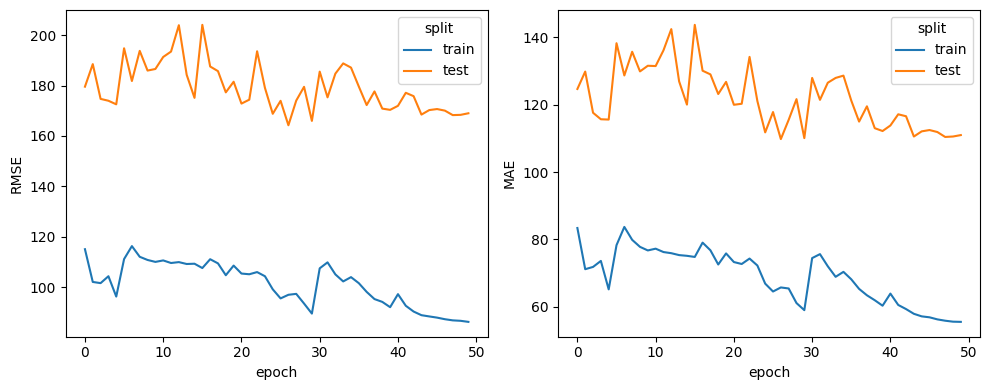

LSTM


  0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

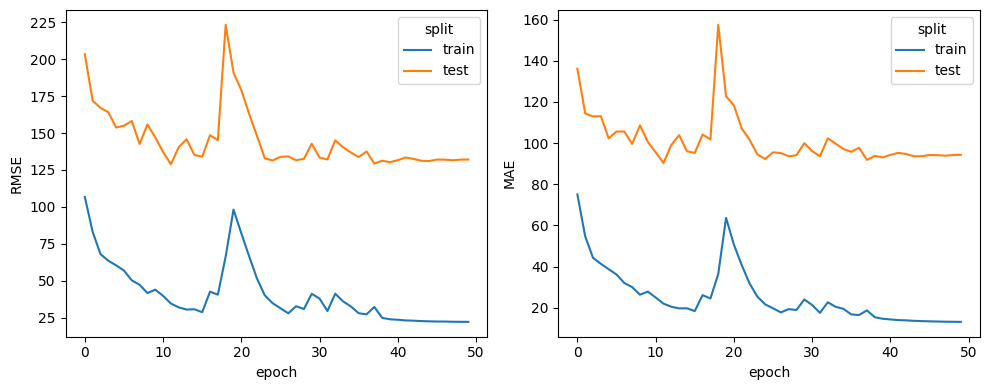

GRU


  0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/34 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

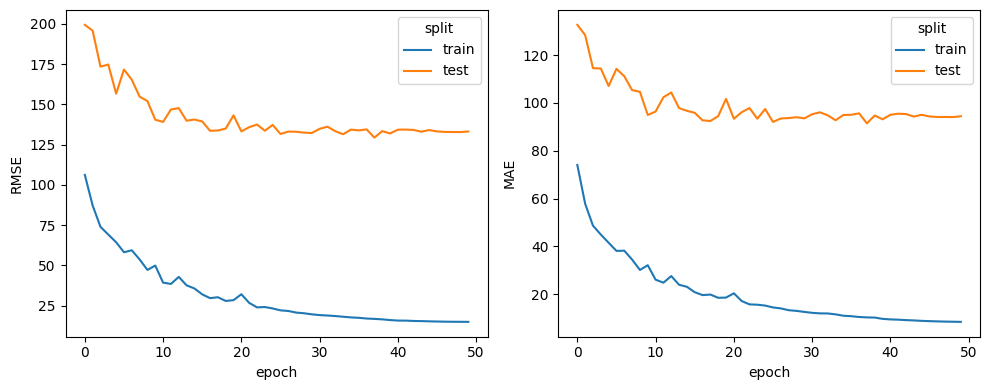

In [ ]:
print('RNN')
rnn_history = fit(
    model       = model_rnn,
    epochs      = epochs,
    trainloader = trainloader,
    testloader  = validloader,
    criterion   = criterion,
    optimizer   = optimizer_rnn,
    scheduler   = scheduler_rnn,
    scaler      = y_scaler,
    savedir     = 'saved_model/RNN',
    seed        = seed
)
history_plot(history=rnn_history)

print('LSTM')
lstm_history = fit(
    model       = model_lstm,
    epochs      = epochs,
    trainloader = trainloader,
    testloader  = testloader,
    criterion   = criterion,
    optimizer   = optimizer_lstm,
    scheduler   = scheduler_lstm,
    scaler      = y_scaler,
    savedir     = 'saved_model/LSTM',
    seed        = seed
)
history_plot(history=lstm_history)

print('GRU')
gru_history = fit(
    model       = model_gru,
    epochs      = epochs,
    trainloader = trainloader,
    testloader  = testloader,
    criterion   = criterion,
    optimizer   = optimizer_gru,
    scheduler   = scheduler_gru,
    scaler      = y_scaler,
    savedir     = 'saved_model/GRU',
    seed        = seed
)
history_plot(history=gru_history)



# Test

In [ ]:
model_rnn.load_state_dict(torch.load('./saved_model/RNN/best_model.pt'))
model_lstm.load_state_dict(torch.load('./saved_model/LSTM/best_model.pt'))
model_gru.load_state_dict(torch.load('./saved_model/GRU/best_model.pt'))

<All keys matched successfully>

In [ ]:
# test
rnn_test_results, rnn_preds = test(
    model        = model_rnn,
    testloader   = testloader,
    criterion    = criterion,
    scaler       = y_scaler,
    return_preds = True
)

# test
lstm_test_results, lstm_preds = test(
    model        = model_lstm,
    testloader   = testloader,
    criterion    = criterion,
    scaler       = y_scaler,
    return_preds = True
)

# test
gru_test_results, gru_preds = test(
    model        = model_gru,
    testloader   = testloader,
    criterion    = criterion,
    scaler       = y_scaler,
    return_preds = True
)

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
results = defaultdict(list)

results['Model'] = ['RNN', 'LSTM', 'GRU']
exp_metrics = [rnn_test_results, lstm_test_results, gru_test_results]
for metrics in exp_metrics:
    for k, v in metrics.items():
        results[k].append(v)

table = pd.DataFrame(results)
table

Model        RMSE         MAE
0   RNN  192.448650  129.096912
1  LSTM  132.056822   94.288082
2   GRU  133.225057   94.440682

## Figure

In [ ]:
df_test = df['2012-06-30' < df['dteday']]

# add preds
df_test['rnn_pred'] = rnn_preds
df_test['lstm_pred'] = lstm_preds
df_test['gru_pred'] = gru_preds

# aggregation
df_test_day = df_test.groupby(['dteday'])[['cnt','rnn_pred','lstm_pred','gru_pred']].sum().reset_index()

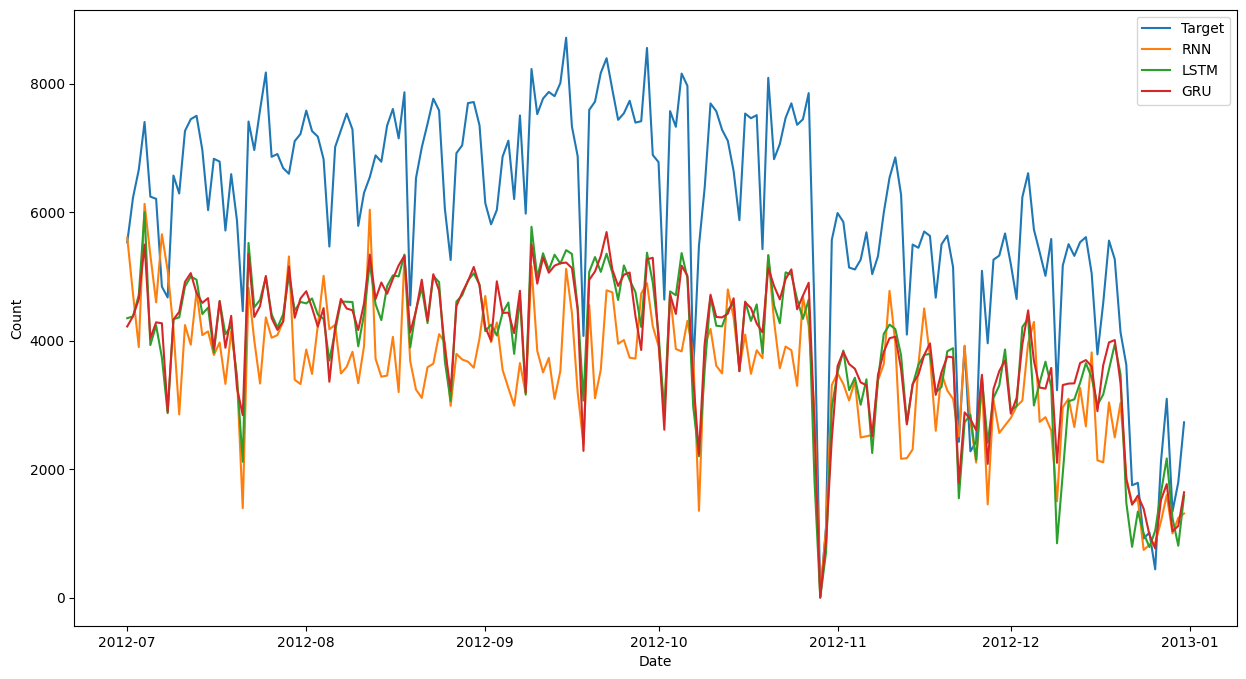

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(x='dteday', y='cnt', data=df_test_day, label='Target', ax=ax)
sns.lineplot(x='dteday', y='rnn_pred', data=df_test_day, label='RNN', ax=ax)
sns.lineplot(x='dteday', y='lstm_pred', data=df_test_day, label='LSTM', ax=ax)
sns.lineplot(x='dteday', y='gru_pred', data=df_test_day, label='GRU', ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Date')
plt.show()